In [1]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

import pickle
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_excel("Dataset/FINAL SUBSET_preprocessed_data.xlsx")    
df1 = data.copy()
df1
# data = Multitime series data that is initially sorted by week_end_date, store_id, upc

,WEEK_END_DATE,YEAR,WEEK_NUM,STORE_ID,UPC,UNIT_SALES,UNIT_SALES_LOG,PRICE,PRICE_SQRT,BASE_PRICE,BASE_PRICE_SQRT,DISCOUNT_RATE,FEATURE,DISPLAY,PROMOTION_SUPPORT,CATEGORY,SUB_CATEGORY,STORE_NAME,SEG_VALUE_NAME,SEG_VALUE_NAME_ORDINAL,SALES_AREA_SIZE_NUM
0,2009-01-14,2009,3,367,1111009477,13,2.564949,1.39,1.178983,1.57,1.252996,0.114650,0,0,UNSUPPORTED,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721
1,2009-01-14,2009,3,367,1111009497,20,2.995732,1.39,1.178983,1.39,1.178983,0.000000,0,0,NONE,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721
2,2009-01-14,2009,3,367,1111009507,14,2.639057,1.38,1.174734,1.38,1.174734,0.000000,0,0,NONE,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721
3,2009-01-14,2009,3,367,1111038078,3,1.098612,2.50,1.581139,2.50,1.581139,0.000000,0,0,NONE,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),15TH & MADISON,VALUE,0,24721
4,2009-01-14,2009,3,367,1111038080,2,0.693147,2.59,1.609348,2.59,1.609348,0.000000,0,0,NONE,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),15TH & MADISON,VALUE,0,24721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414932,2012-01-04,2012,1,29159,31254742735,1,0.000000,4.97,2.229350,4.97,2.229350,0.000000,0,0,NONE,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),CARROLLTON,MAINSTREAM,1,54927
414933,2012-01-04,2012,1,29159,31254742835,5,1.609438,4.97,2.229350,4.97,2.229350,0.000000,0,0,NONE,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),CARROLLTON,MAINSTREAM,1,54927
414934,2012-01-04,2012,1,29159,88491201426,32,3.465736,3.31,1.819341,3.31,1.819341,0.000000,0,0,NONE,COLD CEREAL,ADULT CEREAL,CARROLLTON,MAINSTREAM,1,54927
414935,2012-01-04,2012,1,29159,88491201427,30,3.401197,3.31,1.819341,3.31,1.819341,0.000000,0,0,NONE,COLD CEREAL,ADULT CEREAL,CARROLLTON,MAINSTREAM,1,54927


#### STORE_ID and UPC Frequency Encoding

In [3]:
# STORE_ID Frequency Encoding
store_id_counts = df1['STORE_ID'].value_counts().to_dict()
store_id_counts = dict(sorted(store_id_counts.items()))
df1.insert(4, 'STORE_ID_COUNT', df1['STORE_ID'].map(store_id_counts))

In [4]:
# UPC Frequency Encoding
upc_counts = df1['UPC'].value_counts().to_dict()
upc_counts = dict(sorted(upc_counts.items()))
df1.insert(6, 'UPC_COUNT', df1['UPC'].map(upc_counts)) 

In [40]:
# Check for STORE_ID with duplicated counts
store_id_counts = df1['STORE_ID'].value_counts()
duplicated_counts = store_id_counts[store_id_counts.duplicated(keep=False)]

if not duplicated_counts.empty:
    print("Stores with the same count:")
    for count in duplicated_counts.index:
        print(f"Store ID: {count}, Count: {store_id_counts[count]}")
else:
    print("No stores have the same count.")

# Total 65274 having same counts (15% of total data)

# Check for UPC with duplicated counts
upc_id_counts = df1['UPC'].value_counts()
duplicated_counts = upc_id_counts[upc_id_counts.duplicated(keep=False)]

if not duplicated_counts.empty:
    print("\nUPC  with the same count:")
    for count in duplicated_counts.index:
        print(f"UPC: {count}, Count: {upc_id_counts[count]}")
else:
    print("No UPC have the same count.")

# all UPC having same counts are under CEREAL category, so assuming that same count might not cause big issue
# 35478 having same UPC (8% of total data)

Stores with the same count:
Store ID: 613, Count: 5596
Store ID: 2277, Count: 5596
Store ID: 28909, Count: 5575
Store ID: 2281, Count: 5575
Store ID: 19265, Count: 5553
Store ID: 623, Count: 5553
Store ID: 23075, Count: 5519
Store ID: 15547, Count: 5519
Store ID: 2495, Count: 5504
Store ID: 13859, Count: 5504
Store ID: 17627, Count: 5504
Store ID: 13827, Count: 5497
Store ID: 11757, Count: 5497
Store ID: 2541, Count: 5238
Store ID: 23067, Count: 5238

UPC  with the same count:
UPC: 1111085345, Count: 11980
UPC: 1600027564, Count: 11980


In [31]:
# Save mapping of STORE_ID to STORE_ID_COUNT and UPC to UPC_COUNT into Excel file
store_id_df = pd.DataFrame(list(store_id_counts.items()), columns=['STORE_ID', 'STORE_ID_COUNT'])
upc_df = pd.DataFrame(list(upc_counts.items()), columns=['UPC', 'UPC_COUNT'])

# with pd.ExcelWriter('Dataset/StoreID UPC Encoding.xlsx', engine='openpyxl') as writer:  
#     store_id_df.to_excel(writer, sheet_name='Store', index=False)
#     upc_df.to_excel(writer, sheet_name='Product', index=False)

In [32]:
display(store_id_df)
display(upc_df)

,STORE_ID,STORE_ID_COUNT
0,2513,5618
1,24991,5616
2,613,5596
3,2277,5596
4,11993,5594
...,...,...
72,2523,4819
73,11967,4684
74,23055,4353
75,387,4310


,UPC,UPC_COUNT
0,1111009477,11934
1,1111009497,11960
2,1111009507,11290
3,1111038078,11249
4,1111038080,10667
5,1111085319,11959
6,1111085345,11980
7,1111085350,11963
8,1111087395,11648
9,1111087396,11571


#### One Hot Encoding of CATEGORY

In [5]:
encoded_category = pd.get_dummies(df1 ['CATEGORY']).astype(int)
df1 = pd.concat([df1, encoded_category], axis=1)
df1[['WEEK_END_DATE', 'STORE_ID', 'UPC', 'CATEGORY', 'BAG SNACKS', 'COLD CEREAL', 'FROZEN PIZZA', 'ORAL HYGIENE PRODUCTS']].sample(5)

,WEEK_END_DATE,STORE_ID,UPC,CATEGORY,BAG SNACKS,COLD CEREAL,FROZEN PIZZA,ORAL HYGIENE PRODUCTS
236324,2010-09-29,2505,1111009477,BAG SNACKS,1,0,0,0
241915,2010-10-13,2523,1111038078,ORAL HYGIENE PRODUCTS,0,0,0,1
101715,2009-10-14,19523,31254742735,ORAL HYGIENE PRODUCTS,0,0,0,1
249088,2010-10-27,23067,7192100339,FROZEN PIZZA,0,0,1,0
307454,2011-03-30,2279,3800031829,COLD CEREAL,0,1,0,0


#### Create Lag Features

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


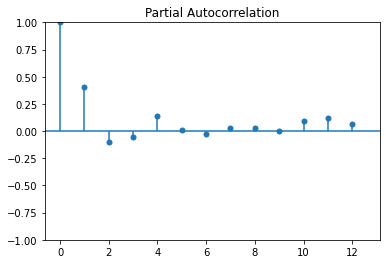

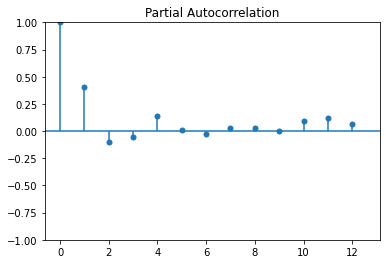

In [56]:
# Partial Autocorrelation Plot shows direct relationships between observations at different time lags. It helps to determine significant lags
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df1["UNIT_SALES_LOG"], lags=12)

In [6]:
print("Before lag features creation: ", df1.shape)

# Group df1 by STORE_ID and UPC so that lag features are shifted by store-product combination.
df1.insert(9, 'UNIT_SALES_LOG_LAG1', df1.groupby(['STORE_ID', 'UPC'])['UNIT_SALES_LOG'].shift(1))
df1.insert(10, 'UNIT_SALES_LOG_LAG2', df1.groupby(['STORE_ID', 'UPC'])['UNIT_SALES_LOG'].shift(2))

# Drop rows (initial periods) with missing values after creating lag features
df1.dropna(inplace=True)
df1.reset_index(inplace = True)
df1.drop(columns=['index'], inplace=True)

print("After lag features creation: ", df1.shape)

Before lag features creation:  (414937, 27)
After lag features creation:  (409247, 29)


In [7]:
# Check if  UNIT_SALES_LOG_LAG1 and UNIT_SALES_LOG_LAG2 shifted correctly
temp = df1.sort_values(by=['STORE_ID', 'UPC']).head(10)
temp[['WEEK_END_DATE', 'STORE_ID', 'UPC', 'UNIT_SALES_LOG', 'UNIT_SALES_LOG_LAG1', 'UNIT_SALES_LOG_LAG2']]

,WEEK_END_DATE,STORE_ID,UPC,UNIT_SALES_LOG,UNIT_SALES_LOG_LAG1,UNIT_SALES_LOG_LAG2
0,2009-01-28,367,1111009477,1.945910,3.178054,2.564949
2425,2009-02-04,367,1111009477,2.484907,1.945910,3.178054
4909,2009-02-11,367,1111009477,2.772589,2.484907,1.945910
7339,2009-02-18,367,1111009477,3.044522,2.772589,2.484907
9795,2009-02-25,367,1111009477,2.397895,3.044522,2.772589
12208,2009-03-04,367,1111009477,2.302585,2.397895,3.044522
14630,2009-03-11,367,1111009477,2.564949,2.302585,2.397895
17087,2009-03-18,367,1111009477,2.564949,2.564949,2.302585
19547,2009-03-25,367,1111009477,2.890372,2.564949,2.564949
22013,2009-04-01,367,1111009477,2.639057,2.890372,2.564949


#### Temporal Split for Train Test Data

In [7]:
unique_weeks = pd.DataFrame(df1['WEEK_END_DATE'].unique(), columns=['WEEK_END_DATE'])
print("Total num of weeks: ", len(unique_weeks))

split_index = int(len(unique_weeks) * 0.8)
print("First ",split_index-1, "weeks of data for training")
date_to_split = unique_weeks['WEEK_END_DATE'].iloc[split_index-1]
print("Split at date: ", date_to_split)

train_df = df1[df1['WEEK_END_DATE'] < date_to_split]
test_df = df1[df1['WEEK_END_DATE'] >= date_to_split]

print("\nTrain: ", train_df['WEEK_END_DATE'].min(), "-", train_df['WEEK_END_DATE'].max())
print("Test: ", test_df['WEEK_END_DATE'].min(), "-", test_df['WEEK_END_DATE'].max())

Total num of weeks:  154
First  122 weeks of data for training
Split at date:  2011-06-01 00:00:00

Train:  2009-01-28 00:00:00 - 2011-05-25 00:00:00
Test:  2011-06-01 00:00:00 - 2012-01-04 00:00:00


#### Define Features and Target

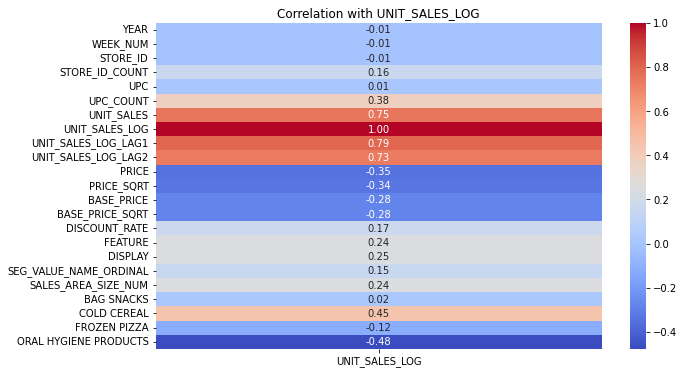

In [17]:
plt.figure(figsize=(10, 6))
sbn.heatmap(df1.corr()[['UNIT_SALES_LOG']], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation with UNIT_SALES_LOG')
plt.show()

In [8]:
# Define X (features) and Y(target) for train and test data
features = ['YEAR','WEEK_NUM','STORE_ID_COUNT','UPC_COUNT','UNIT_SALES_LOG_LAG1','UNIT_SALES_LOG_LAG2',
            'PRICE','FEATURE','DISPLAY','SEG_VALUE_NAME_ORDINAL','SALES_AREA_SIZE_NUM',
            'BAG SNACKS','COLD CEREAL','FROZEN PIZZA','ORAL HYGIENE PRODUCTS']
target = ['UNIT_SALES_LOG']

X_train =  train_df[features]
Y_train =  train_df[target]
X_test =  test_df[features]
Y_test  = test_df[target]

print("X train: ", X_train.shape)
print("Y train: ", Y_train.shape)
print("X test: ", X_test.shape)
print("Y test: ", Y_test.shape)

X train:  (326205, 15)
Y train:  (326205, 1)
X test:  (83042, 15)
Y test:  (83042, 1)


### Evaluation Functions

In [9]:
def plot_feature_importance(X_train, model, model_name):
    feature_importance_df = pd.DataFrame({
        'Features': X_train.columns,
        'Importance Score': model.feature_importances_
    }).sort_values(by='Importance Score', ascending=False)
    display(feature_importance_df)
    
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df['Features'], feature_importance_df['Importance Score'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance of ' + model_name)
    plt.gca().invert_yaxis() 
    plt.show()
    

def evaluate_model(y_actual,y_pred):
    y_actual = np.exp(y_actual)
    y_actual = np.round(y_actual).astype(int)

    y_pred = np.exp(y_pred)
    y_pred = np.round(y_pred).astype(int)

    r2 = r2_score(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    ape = np.abs(y_actual - y_pred.reshape(-1,1))
    wape = ape.sum() / y_actual.sum()
   
    print("\tR-Squared: ", r2)
    print("\tMean Absolute Error: ", mae)
    print("\tWeighted Absolute Percentage Error: ", wape.values[0])


def plot_actual_pred(y_actual,y_pred):
    y_actual = np.exp(y_actual)
    y_actual = np.round(y_actual).astype(int)
    y_pred = np.exp(y_pred)
    y_pred = np.round(y_pred).astype(int)
    
    actual_pred_df = pd.DataFrame(y_pred, columns=['Prediction'])
    actual_pred_df = pd.concat([y_actual.reset_index(drop=True), actual_pred_df], axis=1)
    actual_pred_df.rename(columns={actual_pred_df.columns[0]: 'Actual'}, inplace=True)
    display(actual_pred_df)

    plt.figure(figsize=(50, 6))
    plt.plot(actual_pred_df['Actual'][4000:4200], label='Actual')
    plt.plot(actual_pred_df['Prediction'][4000:4200], label='Prediction')
    plt.legend()
    plt.show()

### Time Series Cross-Validation

In [10]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

def time_series_cross_validation(model):
    df_cv = df1.copy()
    r2_scores = []
    mae_scores = []
    wape_scores = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(df_cv)):
        X_train = df_cv.iloc[train_idx][features]
        Y_train = df_cv.iloc[train_idx][target]
        X_test = df_cv.iloc[test_idx][features]
        Y_test = df_cv.iloc[test_idx][target]
        print("\nFold: {}".format(fold))
        print("\tTrain Indices: ", train_idx)
        print("\tTest Indices: ", test_idx)
        print("\tTrain Shape: ", X_train.shape, Y_train.shape)
        print("\tTest Shape: ", X_test.shape, Y_test.shape)

        model.fit(X_train, np.ravel(Y_train))
        y_pred = model.predict(X_test)

        y_test = np.exp(Y_test)
        y_pred = np.exp(y_pred)

        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        ape = np.abs(np.ravel(y_test) - y_pred)
        wape = ape.sum() / y_test.sum()
        wape = wape.values[0]
        
        print(f"\tR²: {r2},  MAE: {mae},  WAPE: {wape}")
        mae_scores.append(mae)
        r2_scores.append(r2)
        wape_scores.append(wape)

    # Calculate the average mean squared error across all folds
    print("\nAverage R-Squared:", np.mean(r2_scores))
    print("Average Mean Absolute Error:", np.mean(mae_scores))
    print("Average Weighted Absolute Percentage Error:", np.mean(wape_scores))

### Random Forest Regression

#### Base Model

In [18]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
print(rf.get_params())
rf.fit(X_train, np.ravel(Y_train))

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


RandomForestRegressor()

,Features,Importance Score
4,UNIT_SALES_LOG_LAG1,0.634608
6,PRICE,0.064921
5,UNIT_SALES_LOG_LAG2,0.061130
1,WEEK_NUM,0.050400
7,FEATURE,0.038425
2,STORE_ID_COUNT,0.037081
10,SALES_AREA_SIZE_NUM,0.031893
3,UPC_COUNT,0.031327
12,COLD CEREAL,0.011209
0,YEAR,0.010661


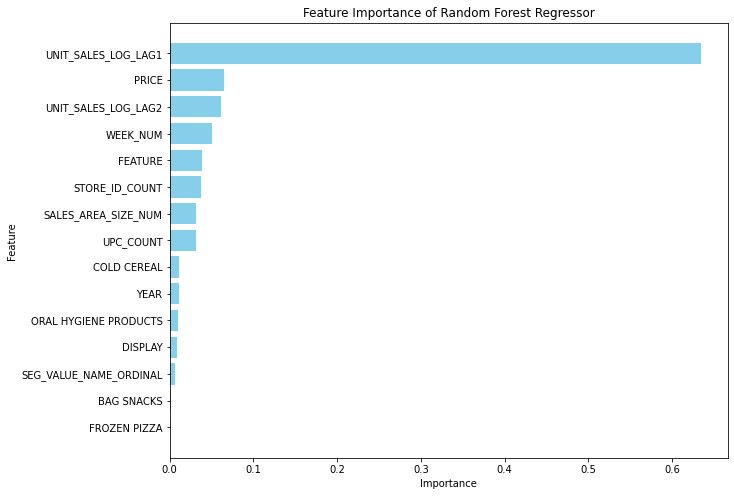

In [21]:
plot_feature_importance(X_train, rf, 'Random Forest Regressor')

##### Training and Testing Evaluation

In [19]:
print("Base Random Forest Regressor Training Evaluation")
rf_train_pred = rf.predict(X_train)
evaluate_model(Y_train, rf_train_pred)

print("Base Random Forest Regressor Testing Evaluation")
rf_test_pred = rf.predict(X_test)
evaluate_model(Y_test, rf_test_pred)

Base Random Forest Regressor Training Evaluation
	R-Squared:  0.9609782629922314
	Mean Absolute Error:  2.5146119771309454
	Weighted Absolute Percentage Error:  0.10919039829358845
Base Random Forest Regressor Testing Evaluation
	R-Squared:  0.7461191797207058
	Mean Absolute Error:  6.805857277040534
	Weighted Absolute Percentage Error:  0.3199111540296821


,Actual,Prediction
0,8,17
1,17,10
2,20,15
3,16,12
4,12,14
...,...,...
83037,1,4
83038,5,2
83039,32,22
83040,30,19


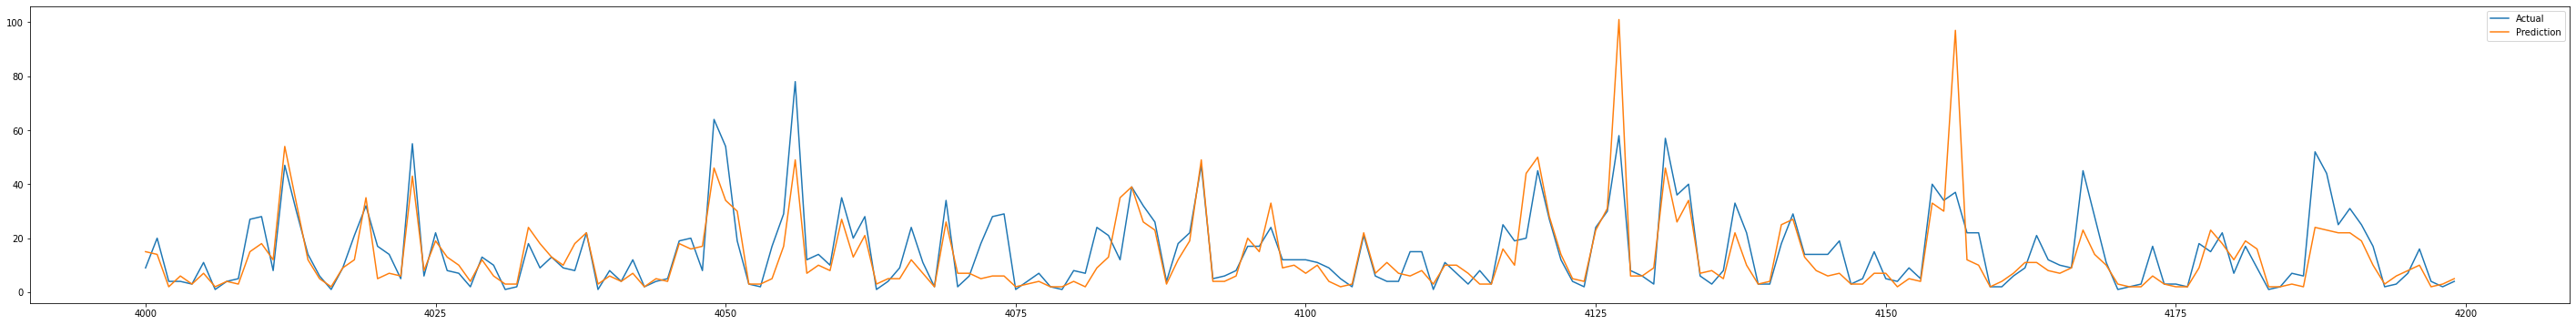

In [20]:
plot_actual_pred(Y_test,rf_test_pred)

##### TSCV

In [11]:
time_series_cross_validation(rf)


Fold: 0
	Train Indices:  [    0     1     2 ... 68209 68210 68211]
	Test Indices:  [ 68212  68213  68214 ... 136416 136417 136418]
	Train Shape:  (68212, 15) (68212, 1)
	Test Shape:  (68207, 15) (68207, 1)
	R²: 0.5369099706063643,  MAE: 9.488845814418749,  WAPE: 0.3937581526529828

Fold: 1
	Train Indices:  [     0      1      2 ... 136416 136417 136418]
	Test Indices:  [136419 136420 136421 ... 204623 204624 204625]
	Train Shape:  (136419, 15) (136419, 1)
	Test Shape:  (68207, 15) (68207, 1)
	R²: 0.7226689079550724,  MAE: 7.461967227767393,  WAPE: 0.32843187656684525

Fold: 2
	Train Indices:  [     0      1      2 ... 204623 204624 204625]
	Test Indices:  [204626 204627 204628 ... 272830 272831 272832]
	Train Shape:  (204626, 15) (204626, 1)
	Test Shape:  (68207, 15) (68207, 1)
	R²: 0.6301976998742931,  MAE: 8.149064300611307,  WAPE: 0.35183606615342744

Fold: 3
	Train Indices:  [     0      1      2 ... 272830 272831 272832]
	Test Indices:  [272833 272834 272835 ... 341037 341038 341

#### Hyperparameter Tuning

In [11]:
param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

rf_grid_search = GridSearchCV(
    estimator = RandomForestRegressor(),
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error',   
    cv = TimeSeriesSplit(n_splits=5),
    verbose=1,     # controls the verbosity of the output during the fitting process
    n_jobs=-1      # specifies the number of jobs to run in parallel. -1 means using all processors available 
)

rf_grid_search.fit(X_train, np.ravel(Y_train))

rf_best_params = rf_grid_search.best_params_
print("Best Parameters: ", rf_best_params)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters:  {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 1000}
Best MAE score from GridSearchCV:  0.4211985342949319


##### Training and Testing Evaluation

In [41]:
print("Tuned Random Forest Regressor Evaluation")
tuned_rf = rf_grid_search.best_estimator_
tuned_rf_pred = tuned_rf.predict(X_test)
evaluate_model(Y_test,tuned_rf_pred)

Tuned Random Forest Regressor Evaluation
	R-Squared:  0.7515176562838286
	Mean Absolute Error:  6.68160689771441
	Weighted Absolute Percentage Error:  0.31407073149056436


In [17]:
tuned_rf1 = RandomForestRegressor(**rf_best_params)
tuned_rf1.fit(X_train, np.ravel(Y_train))

RandomForestRegressor(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=1000)

In [13]:
with open('tuned_rf1.pkl', 'rb') as file:
    tuned_rf1 = pickle.load(file)

In [43]:
print("Tuned Random Forest Regressor Training Evaluation")
rf_train_pred = tuned_rf1.predict(X_train)
evaluate_model(Y_train, rf_train_pred)

print("Tuned Random Forest Regressor Testing Evaluation")
tuned_rf_pred = tuned_rf1.predict(X_test) 
evaluate_model(Y_test,tuned_rf_pred)

Tuned Random Forest Regressor Training Evaluation
	R-Squared:  0.875390057342751
	Mean Absolute Error:  4.982189114207324
	Weighted Absolute Percentage Error:  0.2163384326097759
Tuned Random Forest Regressor Testing Evaluation
	R-Squared:  0.7804482176477241
	Mean Absolute Error:  6.2491871583054355
	Weighted Absolute Percentage Error:  0.29374472519504397


,Actual,Prediction
0,8,16
1,17,12
2,20,14
3,16,14
4,12,16
...,...,...
83037,1,4
83038,5,2
83039,32,21
83040,30,18


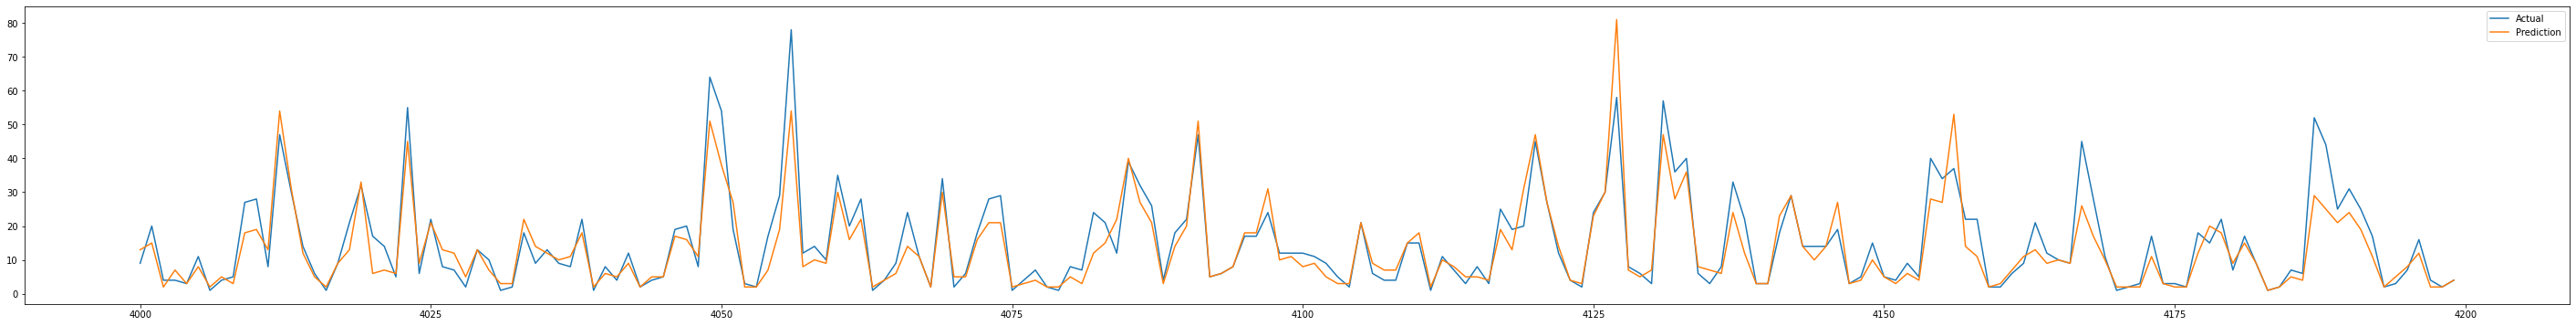

In [15]:
plot_actual_pred(Y_test,tuned_rf_pred)

##### TSCV

In [23]:
time_series_cross_validation(tuned_rf1)


Fold: 0
	Train Indices:  [    0     1     2 ... 68209 68210 68211]
	Test Indices:  [ 68212  68213  68214 ... 136416 136417 136418]
	Train Shape:  (68212, 15) (68212, 1)
	Test Shape:  (68207, 15) (68207, 1)
	R²: 0.5416571810749498,  MAE: 9.254585464526695,  WAPE: 0.3840370628157793

Fold: 1
	Train Indices:  [     0      1      2 ... 136416 136417 136418]
	Test Indices:  [136419 136420 136421 ... 204623 204624 204625]
	Train Shape:  (136419, 15) (136419, 1)
	Test Shape:  (68207, 15) (68207, 1)
	R²: 0.718853306064715,  MAE: 7.406371597764039,  WAPE: 0.3259848841674454

Fold: 2
	Train Indices:  [     0      1      2 ... 204623 204624 204625]
	Test Indices:  [204626 204627 204628 ... 272830 272831 272832]
	Train Shape:  (204626, 15) (204626, 1)
	Test Shape:  (68207, 15) (68207, 1)
	R²: 0.6310674541775945,  MAE: 8.065051258380713,  WAPE: 0.3482088008388346

Fold: 3
	Train Indices:  [     0      1      2 ... 272830 272831 272832]
	Test Indices:  [272833 272834 272835 ... 341037 341038 341039

### XGBoost Regressor

#### Base Model

In [15]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
print(xgb.get_params())
xgb.fit(X_train, np.ravel(Y_train))

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

,Features,Importance Score
4,UNIT_SALES_LOG_LAG1,0.587360
7,FEATURE,0.107224
12,COLD CEREAL,0.059496
8,DISPLAY,0.052337
5,UNIT_SALES_LOG_LAG2,0.047942
14,ORAL HYGIENE PRODUCTS,0.042958
6,PRICE,0.017532
13,FROZEN PIZZA,0.015192
3,UPC_COUNT,0.014730
2,STORE_ID_COUNT,0.011702


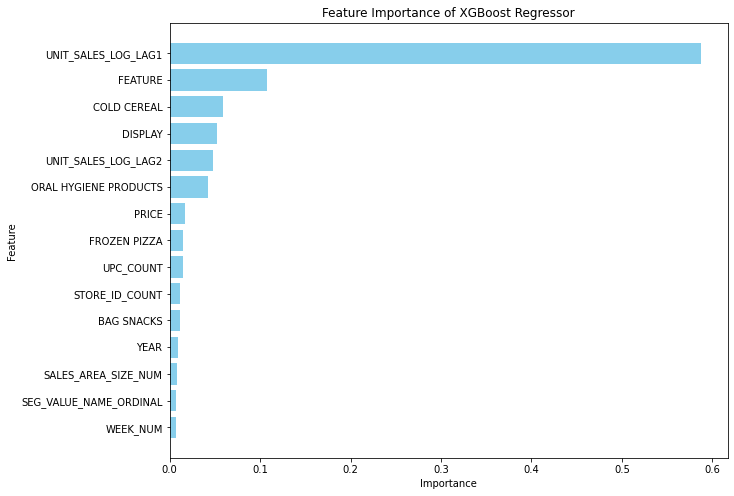

In [16]:
plot_feature_importance(X_train, xgb, 'XGBoost Regressor')

##### Training and Testing Evaluation

In [17]:
xgb_train_pred = xgb.predict(X_train)
print("Base XGBoost Regressor Training Evaluation")
evaluate_model(Y_train,xgb_train_pred)

xgb_test_pred = xgb.predict(X_test)
print("Base XGBoost Regressor Testing Evaluation")
evaluate_model(Y_test,xgb_test_pred)

Base XGBoost Regressor Training Evaluation
	R-Squared:  0.8309992173427713
	Mean Absolute Error:  6.09384896000981
	Weighted Absolute Percentage Error:  0.264609331831633
Base XGBoost Regressor Testing Evaluation
	R-Squared:  0.766387850286538
	Mean Absolute Error:  6.653030996363286
	Weighted Absolute Percentage Error:  0.3127275135524633


,Actual,Prediction
0,8,16
1,17,11
2,20,10
3,16,10
4,12,16
...,...,...
83037,1,5
83038,5,3
83039,32,19
83040,30,21


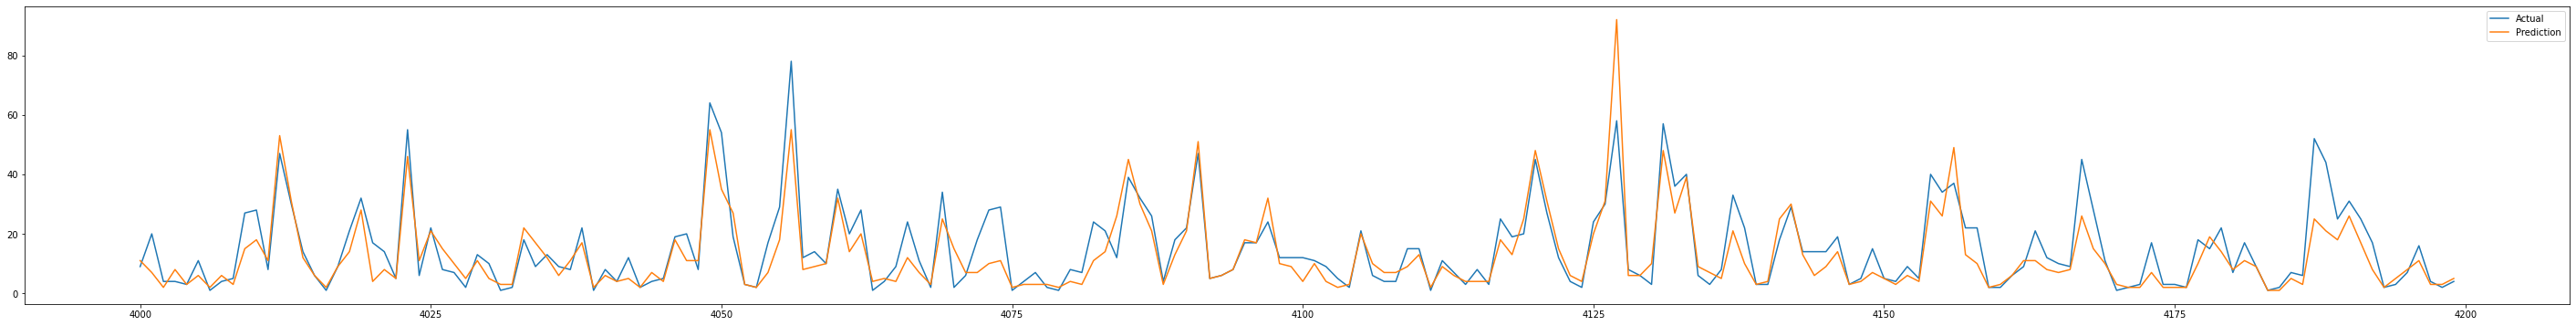

In [18]:
plot_actual_pred(Y_test,xgb_test_pred)

##### TSCV

In [19]:
time_series_cross_validation(xgb)


Fold: 0
	Train Indices:  [    0     1     2 ... 68209 68210 68211]
	Test Indices:  [ 68212  68213  68214 ... 136416 136417 136418]
	Train Shape:  (68212, 15) (68212, 1)
	Test Shape:  (68207, 15) (68207, 1)
	R²: 0.6032690405845642,  MAE: 9.06797514915788,  WAPE: 0.3762933040401904

Fold: 1
	Train Indices:  [     0      1      2 ... 136416 136417 136418]
	Test Indices:  [136419 136420 136421 ... 204623 204624 204625]
	Train Shape:  (136419, 15) (136419, 1)
	Test Shape:  (68207, 15) (68207, 1)
	R²: 0.7426979541778564,  MAE: 7.395170502566392,  WAPE: 0.32549187788598155

Fold: 2
	Train Indices:  [     0      1      2 ... 204623 204624 204625]
	Test Indices:  [204626 204627 204628 ... 272830 272831 272832]
	Train Shape:  (204626, 15) (204626, 1)
	Test Shape:  (68207, 15) (68207, 1)
	R²: 0.6545489430427551,  MAE: 7.869570696209023,  WAPE: 0.3397689224102415

Fold: 3
	Train Indices:  [     0      1      2 ... 272830 272831 272832]
	Test Indices:  [272833 272834 272835 ... 341037 341038 34103

#### Hyperparameter Tuning

In [59]:
param_grid = {
    'n_estimators': [90, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2], # determine how fast the XGBoost model learns
    'max_depth': [6, 9, 12],
    'subsample': [0.4, 0.8] ,          # fraction of observations  take for constructing each tree
    'colsample_bytree':[0.4, 0.8]      # fraction of columns  take for constructing each tree
}

xgb_grid_search = GridSearchCV(
    estimator = XGBRegressor(),
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error',
    cv = TimeSeriesSplit(n_splits=5),
    verbose = 1,
    n_jobs = -1
)

xgb_grid_search.fit(X_train, Y_train)

xgb_best_params = xgb_grid_search.best_params_
print("Best Parameters: ", xgb_best_params)

xgb_best_score = xgb_grid_search.best_score_
print("Best MAE score from GridSearchCV: ", -xgb_best_score)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters:  {'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.8}
Best MAE score from GridSearchCV:  0.4037281757212351


##### Training and Testing Evaluation

In [63]:
print("Tuned XGBoost Regressor Est Evaluation")
tuned_xgb_est = xgb_grid_search.best_estimator_
tuned_xgb_pred = tuned_xgb_est.predict(X_test)
evaluate_model(Y_test, tuned_xgb_pred)

Tuned XGBoost Regressor Est Evaluation
	R-Squared:  0.781498677030695
	Mean Absolute Error:  6.456214927386142
	Weighted Absolute Percentage Error:  0.30347612123037176


In [19]:
tuned_xgb = XGBRegressor(**xgb_best_params)
tuned_xgb.fit(X_train, np.ravel(Y_train))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
print("Tuned XGBoost Regressor Training Evaluation")
xgb_train_pred = tuned_xgb.predict(X_train)
evaluate_model(Y_train,xgb_train_pred)

Tuned XGBoost Regressor Training Evaluation
	R-Squared:  0.8766072714268057
	Mean Absolute Error:  5.406731963029383
	Weighted Absolute Percentage Error:  0.23477308701258576


In [22]:
print("Tuned XGBoost Regressor Testing Evaluation")
tuned_xgb_pred = tuned_xgb.predict(X_test)
evaluate_model(Y_test, tuned_xgb_pred)

Tuned XGBoost Regressor Testing Evaluation
	R-Squared:  0.781498677030695
	Mean Absolute Error:  6.456214927386142
	Weighted Absolute Percentage Error:  0.30347612123037176


,Actual,Prediction
0,8,17
1,17,12
2,20,11
3,16,9
4,12,19
...,...,...
83037,1,4
83038,5,2
83039,32,23
83040,30,22


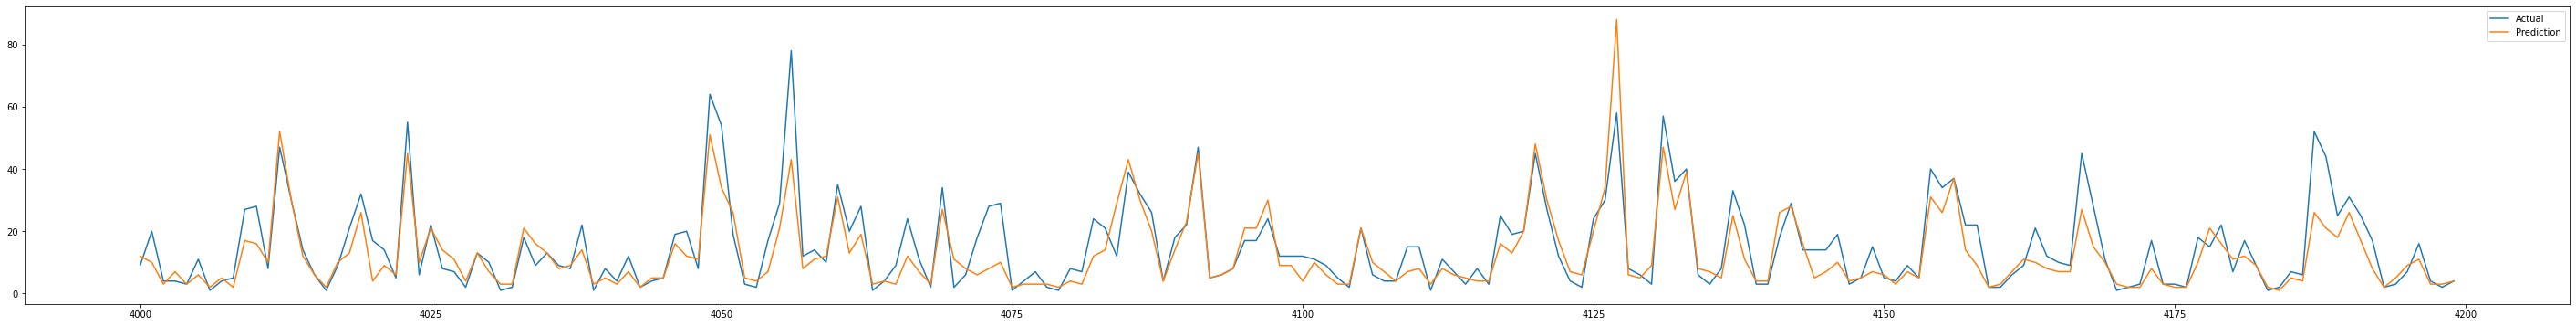

In [23]:
plot_actual_pred(Y_test,tuned_xgb_pred)

##### TSCV

In [29]:
time_series_cross_validation(tuned_xgb)


Fold: 0
	Train Indices:  [    0     1     2 ... 68209 68210 68211]
	Test Indices:  [ 68212  68213  68214 ... 136416 136417 136418]
	Train Shape:  (68212, 15) (68212, 1)
	Test Shape:  (68207, 15) (68207, 1)
	R²: 0.6724244356155396,  MAE: 8.550970766015716,  WAPE: 0.3548391994208265

Fold: 1
	Train Indices:  [     0      1      2 ... 136416 136417 136418]
	Test Indices:  [136419 136420 136421 ... 204623 204624 204625]
	Train Shape:  (136419, 15) (136419, 1)
	Test Shape:  (68207, 15) (68207, 1)
	R²: 0.749679446220398,  MAE: 7.069830385015534,  WAPE: 0.311172320848517

Fold: 2
	Train Indices:  [     0      1      2 ... 204623 204624 204625]
	Test Indices:  [204626 204627 204628 ... 272830 272831 272832]
	Train Shape:  (204626, 15) (204626, 1)
	Test Shape:  (68207, 15) (68207, 1)
	R²: 0.6755763292312622,  MAE: 7.638995278328524,  WAPE: 0.3298138226606086

Fold: 3
	Train Indices:  [     0      1      2 ... 272830 272831 272832]
	Test Indices:  [272833 272834 272835 ... 341037 341038 341039]

In [21]:
with open('best_xgb_2.pkl', 'rb') as file:
    xgb2 = pickle.load(file)

In [72]:
xgb_train_pred = xgb2.predict(X_train)
print("Base XGBoost Regressor Training Evaluation")
evaluate_model(Y_train,xgb_train_pred)

xgb_test_pred = xgb2.predict(X_test)
print("Base XGBoost Regressor Testing Evaluation")
evaluate_model(Y_test,xgb_test_pred)

Base XGBoost Regressor Training Evaluation
	R-Squared:  0.8766072714268057
	Mean Absolute Error:  5.406731963029383
	Weighted Absolute Percentage Error:  0.23477308701258576
Base XGBoost Regressor Testing Evaluation
	R-Squared:  0.781498677030695
	Mean Absolute Error:  6.456214927386142
	Weighted Absolute Percentage Error:  0.30347612123037176


### Save Tuned XGBoost Regression as Best Model

In [ ]:
# Save the tuned XGBoostRegressor as the best demand forecasting model
# import pickle
# with open('best_xgb_2.pkl', 'wb') as file:
#     pickle.dump(tuned_xgb, file)

### Data Preparation for LSTM

#### Temporal Split for Train Test Data

In [11]:
# Train test data spliting
lstm_train_df = train_df.copy()
lstm_test_df = test_df.copy()
display(lstm_train_df)
display(lstm_test_df)

,WEEK_END_DATE,YEAR,WEEK_NUM,STORE_ID,STORE_ID_COUNT,UPC,UPC_COUNT,UNIT_SALES,UNIT_SALES_LOG,UNIT_SALES_LOG_LAG1,UNIT_SALES_LOG_LAG2,PRICE,PRICE_SQRT,BASE_PRICE,BASE_PRICE_SQRT,DISCOUNT_RATE,FEATURE,DISPLAY,PROMOTION_SUPPORT,CATEGORY,SUB_CATEGORY,STORE_NAME,SEG_VALUE_NAME,SEG_VALUE_NAME_ORDINAL,SALES_AREA_SIZE_NUM,BAG SNACKS,COLD CEREAL,FROZEN PIZZA,ORAL HYGIENE PRODUCTS
0,2009-01-28,2009,5,367,4941,1111009477,11934,7,1.945910,3.178054,2.564949,1.36,1.166190,1.36,1.166190,0.000000,0,0,NONE,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721,1,0,0,0
1,2009-01-28,2009,5,367,4941,1111009497,11960,19,2.944439,2.197225,2.995732,1.38,1.174734,1.38,1.174734,0.000000,0,0,NONE,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721,1,0,0,0
2,2009-01-28,2009,5,367,4941,1111009507,11290,11,2.397895,2.397895,2.639057,1.38,1.174734,1.38,1.174734,0.000000,0,0,NONE,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721,1,0,0,0
3,2009-01-28,2009,5,367,4941,1111038080,10667,5,1.609438,2.944439,0.693147,0.96,0.979796,2.59,1.609348,0.629344,0,0,UNSUPPORTED,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),15TH & MADISON,VALUE,0,24721,0,0,0,1
4,2009-01-28,2009,5,367,4941,1111085319,11959,18,2.890372,2.484907,2.639057,1.87,1.367479,1.87,1.367479,0.000000,0,0,NONE,COLD CEREAL,ALL FAMILY CEREAL,15TH & MADISON,VALUE,0,24721,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326200,2011-05-25,2011,21,29159,5529,31254742735,11072,4,1.386294,1.098612,1.098612,4.83,2.197726,4.83,2.197726,0.000000,0,1,SUPPORTED,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),CARROLLTON,MAINSTREAM,1,54927,0,0,0,1
326201,2011-05-25,2011,21,29159,5529,31254742835,10465,9,2.197225,1.945910,0.693147,4.83,2.197726,4.83,2.197726,0.000000,0,1,SUPPORTED,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),CARROLLTON,MAINSTREAM,1,54927,0,0,0,1
326202,2011-05-25,2011,21,29159,5529,88491201426,10700,22,3.091042,3.332205,3.178054,3.19,1.786057,3.19,1.786057,0.000000,0,0,NONE,COLD CEREAL,ADULT CEREAL,CARROLLTON,MAINSTREAM,1,54927,0,1,0,0
326203,2011-05-25,2011,21,29159,5529,88491201427,10313,25,3.218876,3.091042,3.637586,3.19,1.786057,3.19,1.786057,0.000000,0,0,NONE,COLD CEREAL,ADULT CEREAL,CARROLLTON,MAINSTREAM,1,54927,0,1,0,0


,WEEK_END_DATE,YEAR,WEEK_NUM,STORE_ID,STORE_ID_COUNT,UPC,UPC_COUNT,UNIT_SALES,UNIT_SALES_LOG,UNIT_SALES_LOG_LAG1,UNIT_SALES_LOG_LAG2,PRICE,PRICE_SQRT,BASE_PRICE,BASE_PRICE_SQRT,DISCOUNT_RATE,FEATURE,DISPLAY,PROMOTION_SUPPORT,CATEGORY,SUB_CATEGORY,STORE_NAME,SEG_VALUE_NAME,SEG_VALUE_NAME_ORDINAL,SALES_AREA_SIZE_NUM,BAG SNACKS,COLD CEREAL,FROZEN PIZZA,ORAL HYGIENE PRODUCTS
326205,2011-06-01,2011,22,367,4941,1111009477,11934,8,2.079442,3.091042,2.772589,1.55,1.244990,1.55,1.244990,0.000000,0,0,NONE,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721,1,0,0,0
326206,2011-06-01,2011,22,367,4941,1111009497,11960,17,2.833213,1.791759,2.833213,1.52,1.232883,1.52,1.232883,0.000000,0,0,NONE,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721,1,0,0,0
326207,2011-06-01,2011,22,367,4941,1111009507,11290,20,2.995732,2.708050,2.484907,1.55,1.244990,1.55,1.244990,0.000000,0,0,NONE,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721,1,0,0,0
326208,2011-06-01,2011,22,367,4941,1111085319,11959,16,2.772589,2.944439,1.386294,1.89,1.374773,1.89,1.374773,0.000000,0,0,NONE,COLD CEREAL,ALL FAMILY CEREAL,15TH & MADISON,VALUE,0,24721,0,1,0,0
326209,2011-06-01,2011,22,367,4941,1111085345,11980,12,2.484907,2.833213,3.218876,1.85,1.360147,1.85,1.360147,0.000000,0,0,NONE,COLD CEREAL,ADULT CEREAL,15TH & MADISON,VALUE,0,24721,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409242,2012-01-04,2012,1,29159,5529,31254742735,11072,1,0.000000,1.098612,1.609438,4.97,2.229350,4.97,2.229350,0.000000,0,0,NONE,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),CARROLLTON,MAINSTREAM,1,54927,0,0,0,1
409243,2012-01-04,2012,1,29159,5529,31254742835,10465,5,1.609438,0.693147,1.098612,4.97,2.229350,4.97,2.229350,0.000000,0,0,NONE,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),CARROLLTON,MAINSTREAM,1,54927,0,0,0,1
409244,2012-01-04,2012,1,29159,5529,88491201426,10700,32,3.465736,2.944439,2.708050,3.31,1.819341,3.31,1.819341,0.000000,0,0,NONE,COLD CEREAL,ADULT CEREAL,CARROLLTON,MAINSTREAM,1,54927,0,1,0,0
409245,2012-01-04,2012,1,29159,5529,88491201427,10313,30,3.401197,2.995732,2.772589,3.31,1.819341,3.31,1.819341,0.000000,0,0,NONE,COLD CEREAL,ADULT CEREAL,CARROLLTON,MAINSTREAM,1,54927,0,1,0,0


#### Define Features and Target

In [12]:
lstm_features = ['YEAR','WEEK_NUM', 'STORE_ID_COUNT','UPC_COUNT','PRICE','FEATURE','DISPLAY',
                 'SEG_VALUE_NAME_ORDINAL','SALES_AREA_SIZE_NUM',
                 'BAG SNACKS','COLD CEREAL','FROZEN PIZZA','ORAL HYGIENE PRODUCTS']
lstm_target = ['UNIT_SALES_LOG']

#### Z-score Standardization

In [13]:
x_scaler = StandardScaler()
lstm_x_train = x_scaler.fit_transform(lstm_train_df[lstm_features])
print("lstm_x_train:", lstm_x_train.shape)

y_scaler = StandardScaler()
lstm_y_train = y_scaler.fit_transform(lstm_train_df[lstm_target])
print("lstm_y_train: ", lstm_y_train.shape)

lstm_x_train: (326205, 13)
lstm_y_train:  (326205, 1)


#### Create Data Sequences

In [14]:
# Create sequences (original order & order by store-product with scaled features/target)

def create_sequences(x_data, y_data, time_steps, len_data):
    X, Y = [], []
    for i in range(time_steps, len_data):
        X.append(x_data[i-time_steps:i])   # [0:2]->[1:3]->[2:4]->[3:5] ...
        Y.append(y_data[i][0])             # [2]->[3]->[4]->[5] ...           
    return np.array(X), np.array(Y)

time_steps = 2
lstm_X_train, lstm_Y_train = create_sequences(lstm_x_train, lstm_y_train, time_steps, len(lstm_train_df))  
print("lstm_X_train: ", lstm_X_train.shape)   
print("lstm_Y_train", lstm_Y_train.shape) 

# Convert data type from float64 to float32
print("\nBefore reshape (lstm_X_train): ", lstm_X_train.dtype)
print("Before reshape (lstm_Y_train): ", lstm_Y_train.dtype)
lstm_X_train = lstm_X_train.astype('float32')
lstm_Y_train = lstm_Y_train.astype('float32')
print("After reshape (lstm_X_train): ", lstm_X_train.dtype)  
print("After reshape (lstm_Y_train): ", lstm_Y_train.dtype)

lstm_X_train:  (326203, 2, 13)
lstm_Y_train (326203,)

Before reshape (lstm_X_train):  float64
Before reshape (lstm_Y_train):  float64
After reshape (lstm_X_train):  float32
After reshape (lstm_Y_train):  float32


In [132]:
lstm_X_train[5:7]

array([[[-1.0925062 , -1.3300098 , -1.7105653 ,  1.0302713 ,
         -0.88918453, -0.32138002, -0.386002  , -1.4676416 ,
         -1.858651  , -0.5222564 ,  1.1891961 , -0.49145392,
         -0.46365887],
        [-1.0925062 , -1.3300098 , -1.7105653 ,  1.0061924 ,
         -0.80767775, -0.32138002, -0.386002  , -1.4676416 ,
         -1.858651  , -0.5222564 ,  1.1891961 , -0.49145392,
         -0.46365887]],

       [[-1.0925062 , -1.3300098 , -1.7105653 ,  1.0061924 ,
         -0.80767775, -0.32138002, -0.386002  , -1.4676416 ,
         -1.858651  , -0.5222564 ,  1.1891961 , -0.49145392,
         -0.46365887],
        [-1.0925062 , -1.3300098 , -1.7105653 ,  0.56002545,
          0.08210441,  3.111581  ,  2.59066   , -1.4676416 ,
         -1.858651  , -0.5222564 , -0.8409042 ,  2.0347788 ,
         -0.46365887]]], dtype=float32)

### LSTM

#### Evaluation Functions

In [15]:
# import tensorflow as tf
from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    rss =  K.sum(K.square(y_true - y_pred)) 
    tss = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - rss/(tss + K.epsilon())  # add epsilon to avoid division by zero

def wape(y_true, y_pred):
    APE = K.abs(y_true - y_pred)
    return K.sum(APE) / K.sum(y_true)


In [16]:
def evaluate_lstm_model(y_actual,y_pred):
    y_actual = np.exp(y_actual)
    y_actual = np.round(y_actual).astype(int)

    y_pred = np.exp(y_pred)
    y_pred = np.round(y_pred).astype(int)

    r2 = r2_score(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    ape = np.abs(y_actual - y_pred)
    wape = ape.sum() / y_actual.sum()
   
    print("\tR-Squared: ", r2)
    print("\tMean Absolute Error: ", mae)
    print("\tWeighted Absolute Percentage Error: ", wape)
    return r2, mae, wape


def plot_actual_pred_lstm(y_actual,y_pred):
    y_actual = np.exp(y_actual)
    y_actual = np.round(y_actual).astype(int)
    y_pred = np.exp(y_pred)
    y_pred = np.round(y_pred).astype(int)

    actual_pred_df = pd.DataFrame(y_pred, columns=['Prediction'])
    actual_pred_df = pd.concat([pd.DataFrame(y_actual, columns=['Actual']).reset_index(drop=True), actual_pred_df], axis=1)
    actual_pred_df.rename(columns={actual_pred_df.columns[0]: 'Actual'}, inplace=True)
    display(actual_pred_df)

    plt.figure(figsize=(50, 6))
    plt.plot(actual_pred_df['Actual'][4000:4200], label='Actual')
    plt.plot(actual_pred_df['Prediction'][4000:4200], label='Prediction')
    plt.legend()
    plt.show()

In [17]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

def lstm_time_series_cross_validation(model):
    df_cv = df1.copy()
    r2_scores = []
    mae_scores = []
    wape_scores = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(df_cv)):
        # time series split
        lstm_train_df = df_cv.iloc[train_idx]
        lstm_test_df = df_cv.iloc[test_idx]
        print("\nFold: {}".format(fold))
        print("\tTrain Indices: ", train_idx)
        print("\tTest Indices: ", test_idx)

        # standardization
        x_scaler = StandardScaler()
        lstm_x_train = x_scaler.fit_transform(lstm_train_df[lstm_features])
        y_scaler = StandardScaler()
        lstm_y_train = y_scaler.fit_transform(lstm_train_df[lstm_target])
        #print("After standardization:", lstm_x_train.shape, lstm_y_train.shape)

        # create sequence
        lstm_X_train, lstm_Y_train = create_sequences(lstm_x_train, lstm_y_train, 2, len(lstm_train_df))  
        print("Train Sequence Data: ", lstm_X_train.shape, lstm_Y_train.shape)   
        lstm_X_train = lstm_X_train.astype('float32')
        lstm_Y_train = lstm_Y_train.astype('float32')

        # fit and train model
        history = model.fit(lstm_X_train, lstm_Y_train, epochs=10, batch_size= 128)

        # testing
        lstm_train_last2 = lstm_train_df.iloc[-2:]   
        lstm_test_full = pd.concat((lstm_train_last2, lstm_test_df), axis=0)

        lstm_x_test = x_scaler.transform(lstm_test_full[lstm_features])
        lstm_y_test = y_scaler.transform(lstm_test_full[lstm_target])

        lstm_X_test, lstm_Y_test  = create_sequences(lstm_x_test, lstm_y_test, time_steps, len(lstm_test_full)) 
        print("Test Sequence Data: ", lstm_X_test.shape, lstm_Y_test.shape) 
        lstm_X_test = lstm_X_test.astype('float32')
        lstm_Y_test = lstm_Y_test.astype('float32')

        # evaluation
        lstm_test_pred = model.predict(lstm_X_test)
        lstm_test_actual = y_scaler.inverse_transform(lstm_Y_test.reshape(-1, 1))
        lstm_test_pred = y_scaler.inverse_transform(lstm_test_pred) 
        r2, mae, wape = evaluate_lstm_model(lstm_test_actual,lstm_test_pred)

        print(f"\tR²: {r2},  MAE: {mae},  WAPE: {wape}")
        mae_scores.append(mae)
        r2_scores.append(r2)
        wape_scores.append(wape)

    # Calculate the average mean squared error across all folds
    print("\nAverage R-Squared:", np.mean(r2_scores))
    print("Average Mean Absolute Error:", np.mean(mae_scores))
    print("Average Weighted Absolute Percentage Error:", np.mean(wape_scores))

#### Base Model

In [18]:
# Define LSTM model architecture
time_steps = lstm_X_train.shape[1]
n_features = lstm_X_train.shape[2]
print("Time steps:", time_steps,  "  Num of Features: ",n_features)

from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

model = Sequential() 
model.add(Input(shape=(time_steps, n_features)))   # Input layer
model.add(LSTM(units=128, return_sequences=True))  # First layer    
model.add(LSTM(units=64, return_sequences=False))  # Second layer
model.add(Dense(units=1))                          # Output layer 

Time steps: 2   Num of Features:  13


In [19]:
for layer in model.layers:
    print(layer.get_config())

{'name': 'lstm', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False, 'units': 128, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'OrthogonalInitializer', 'config': {'gain': 1.0, 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'seed': None}
{'name': 'lstm_1', 't

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 2, 128)         │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,177 (477.25 KB)

 Trainable params: 122,177 (477.25 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Compile and fit LSTM model
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[r_squared])
history = model.fit(lstm_X_train, lstm_Y_train, epochs=10, batch_size= 128)

Epoch 1/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - loss: 0.6091 - r_squared: -175.6084
Epoch 2/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.4972 - r_squared: -200.8408
Epoch 3/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - loss: 0.4807 - r_squared: -204.0776
Epoch 4/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - loss: 0.4712 - r_squared: -205.2799
Epoch 5/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.4637 - r_squared: -206.6727
Epoch 6/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.4549 - r_squared: -208.3537
Epoch 7/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.4527 - r_squared: -208.2977
Epoch 8/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - loss: 0.4462 - r_squared: -209.9899
Epoch 9/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.4402 - r_squared: -210.8446
Epoch 10/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - loss: 0.4358 - r_squared: -211.4792


##### Training Evaluation

In [33]:
# Training Evaluation
lstm_train_pred = model.predict(lstm_X_train)

lstm_train_actual = y_scaler.inverse_transform(lstm_Y_train.reshape(-1, 1))
lstm_train_pred = y_scaler.inverse_transform(lstm_train_pred) 

print("Base LSTM Training Evaluation")
evaluate_lstm_model(lstm_train_actual,lstm_train_pred)

10194/10194 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step
Base LSTM Training Evaluation
	R-Squared:  0.47241480405871095
	Mean Absolute Error:  9.713874489198444
	Weighted Absolute Percentage Error:  0.421798274227748


(0.47241480405871095, 9.713874489198444, 0.421798274227748)

##### Testing Evaluation

In [55]:
# Concatenate last 2 records of training set to create full test set
lstm_train_last2 = lstm_train_df.iloc[-2:]   #-2 means taking the last 2 records of train_df. Depending on time step
lstm_train_last2
lstm_test_full = pd.concat((lstm_train_last2, lstm_test_df), axis=0)
print("lstm_test_full: ", lstm_test_full.shape)
lstm_test_full

lstm_test_full:  (83044, 29)


,WEEK_END_DATE,YEAR,WEEK_NUM,STORE_ID,STORE_ID_COUNT,UPC,UPC_COUNT,UNIT_SALES,UNIT_SALES_LOG,UNIT_SALES_LOG_LAG1,UNIT_SALES_LOG_LAG2,PRICE,PRICE_SQRT,BASE_PRICE,BASE_PRICE_SQRT,DISCOUNT_RATE,FEATURE,DISPLAY,PROMOTION_SUPPORT,CATEGORY,SUB_CATEGORY,STORE_NAME,SEG_VALUE_NAME,SEG_VALUE_NAME_ORDINAL,SALES_AREA_SIZE_NUM,BAG SNACKS,COLD CEREAL,FROZEN PIZZA,ORAL HYGIENE PRODUCTS
326203,2011-05-25,2011,21,29159,5529,88491201427,10313,25,3.218876,3.091042,3.637586,3.19,1.786057,3.19,1.786057,0.000000,0,0,NONE,COLD CEREAL,ADULT CEREAL,CARROLLTON,MAINSTREAM,1,54927,0,1,0,0
326204,2011-05-25,2011,21,29159,5529,88491212971,10091,8,2.079442,1.098612,2.564949,2.99,1.729162,2.99,1.729162,0.000000,0,0,NONE,COLD CEREAL,KIDS CEREAL,CARROLLTON,MAINSTREAM,1,54927,0,1,0,0
326205,2011-06-01,2011,22,367,4941,1111009477,11934,8,2.079442,3.091042,2.772589,1.55,1.244990,1.55,1.244990,0.000000,0,0,NONE,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721,1,0,0,0
326206,2011-06-01,2011,22,367,4941,1111009497,11960,17,2.833213,1.791759,2.833213,1.52,1.232883,1.52,1.232883,0.000000,0,0,NONE,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721,1,0,0,0
326207,2011-06-01,2011,22,367,4941,1111009507,11290,20,2.995732,2.708050,2.484907,1.55,1.244990,1.55,1.244990,0.000000,0,0,NONE,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409242,2012-01-04,2012,1,29159,5529,31254742735,11072,1,0.000000,1.098612,1.609438,4.97,2.229350,4.97,2.229350,0.000000,0,0,NONE,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),CARROLLTON,MAINSTREAM,1,54927,0,0,0,1
409243,2012-01-04,2012,1,29159,5529,31254742835,10465,5,1.609438,0.693147,1.098612,4.97,2.229350,4.97,2.229350,0.000000,0,0,NONE,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),CARROLLTON,MAINSTREAM,1,54927,0,0,0,1
409244,2012-01-04,2012,1,29159,5529,88491201426,10700,32,3.465736,2.944439,2.708050,3.31,1.819341,3.31,1.819341,0.000000,0,0,NONE,COLD CEREAL,ADULT CEREAL,CARROLLTON,MAINSTREAM,1,54927,0,1,0,0
409245,2012-01-04,2012,1,29159,5529,88491201427,10313,30,3.401197,2.995732,2.772589,3.31,1.819341,3.31,1.819341,0.000000,0,0,NONE,COLD CEREAL,ADULT CEREAL,CARROLLTON,MAINSTREAM,1,54927,0,1,0,0


In [56]:
# Z-Score Standardization of Test Set
lstm_x_test = x_scaler.transform(lstm_test_full[lstm_features])
print("lstm_x_test: ", lstm_x_test.shape)

lstm_y_test = y_scaler.transform(lstm_test_full[lstm_target])
print("lstm_y_test: ", lstm_y_test.shape)

lstm_x_test:  (83044, 13)
lstm_y_test:  (83044, 1)


In [57]:
# Create Sequence for Test Set
time_steps = 2
lstm_X_test, lstm_Y_test  = create_sequences(lstm_x_test, lstm_y_test, time_steps, len(lstm_test_full)) 

print("lstm_X_test: ", lstm_X_test.shape)  
print("lstm_Y_test: ", lstm_Y_test.shape) 

print("\nBefore reshape (lstm_X_test): ", lstm_X_test.dtype)
print("Before reshape (lstm_Y_test): ", lstm_Y_test.dtype)
lstm_X_test = lstm_X_test.astype('float32')
lstm_Y_test = lstm_Y_test.astype('float32')
print("After reshape (lstm_X_test): ", lstm_X_test.dtype)
print("After reshape (lstm_Y_test): ", lstm_Y_test.dtype)

lstm_X_test:  (83042, 2, 13)
lstm_Y_test:  (83042,)

Before reshape (lstm_X_test):  float64
Before reshape (lstm_Y_test):  float64
After reshape (lstm_X_test):  float32
After reshape (lstm_Y_test):  float32


In [38]:
lstm_test_pred = model.predict(lstm_X_test)

lstm_test_actual = y_scaler.inverse_transform(lstm_Y_test.reshape(-1, 1))
lstm_test_pred = y_scaler.inverse_transform(lstm_test_pred) 

print("Base LSTM Testing Evaluation")
evaluate_lstm_model(lstm_test_actual,lstm_test_pred)

2596/2596 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step
Base LSTM Testing Evaluation
	R-Squared:  0.366579113156312
	Mean Absolute Error:  10.85818019797211
	Weighted Absolute Percentage Error:  0.510391684162085


(0.366579113156312, 10.85818019797211, 0.510391684162085)

,Actual,Prediction
0,8,36
1,17,15
2,20,11
3,16,5
4,12,13
...,...,...
83037,1,11
83038,5,3
83039,32,32
83040,30,25


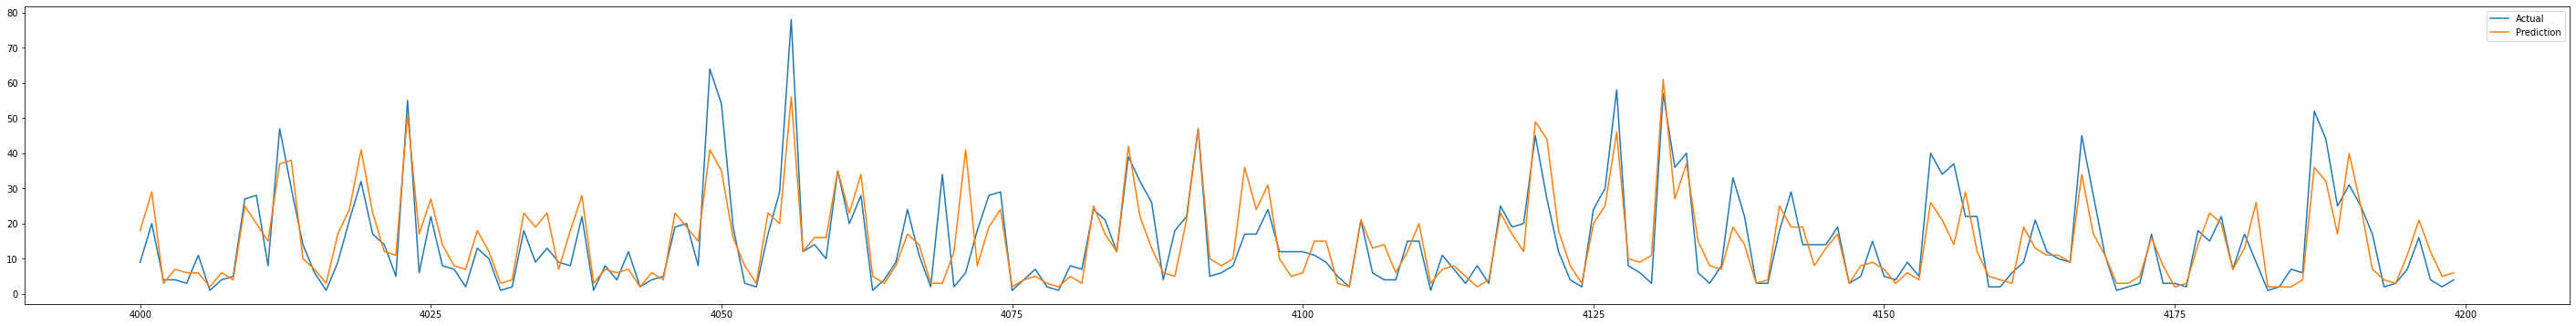

In [39]:
plot_actual_pred_lstm(lstm_test_actual,lstm_test_pred)

##### TSCV

In [40]:
lstm_time_series_cross_validation(model)


Fold: 0
	Train Indices:  [    0     1     2 ... 68209 68210 68211]
	Test Indices:  [ 68212  68213  68214 ... 136416 136417 136418]
Train Sequence Data:  (68210, 2, 13) (68210,)
Epoch 1/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.4471 - r_squared: -210.4255
Epoch 2/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.4289 - r_squared: -212.9555
Epoch 3/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.4217 - r_squared: -213.6527
Epoch 4/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.4195 - r_squared: -213.9583
Epoch 5/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.4158 - r_squared: -214.2758
Epoch 6/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.4108 - r_squared: -214.9200
Epoch 7/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.4057 - r_squared: -216.0594
Epoch 8/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.4032 - r_squared: -216.1578
Epoch 9/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.4037 - r_squared: -216.8140
Epo

#### Hyperparameter Tuning using Random Search

In [46]:
time_steps = lstm_X_train.shape[1]
n_features = lstm_X_train.shape[2]
print("Time steps:", time_steps,  "  Num of Features: ",n_features)

import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Dropout

def build_lstm_model(hp):
    model = Sequential()    
    # Input layer
    model.add(Input(shape=(time_steps, n_features)))
    # First LSTM layer with hyperparameters for units, activation, dropout
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=256, step=32),  
                   return_sequences=True, 
                   activation=hp.Choice('activation_1', values=['relu', 'tanh'])))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    # Second LSTM layer with hyperparameters for units, activation, dropout
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=128, step=32),
                   return_sequences=False, 
                   activation=hp.Choice('activation_2', values=['relu', 'tanh'])))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))   
    # Dense layer
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])), loss='mean_absolute_error', metrics=[r_squared])
    return model

Time steps: 2   Num of Features:  13


In [41]:
tuner = kt.RandomSearch(
    build_lstm_model,
    objective = 'val_loss',     # val_loss: value of loss function calculated on the validation dataset
    max_trials = 5,             # Number of different hyperparameter combinations to try
    executions_per_trial = 2,   # Number of models to train with each set of hyperparameters
    overwrite = True,
    directory = 'tuner',
    project_name = 'lstm_hyperparameter_tuning')

tuner.search_space_summary()

# Define early stopping to prevent overfitting
early_stopper = EarlyStopping(monitor='val_loss', patience=5) 

tuner.search(lstm_X_train, lstm_Y_train, epochs=10, batch_size=128, validation_data=(lstm_X_test, lstm_Y_test), callbacks=[early_stopper])

Trial 5 Complete [00h 10m 56s]
val_loss: 0.5064077973365784

Best val_loss So Far: 0.5024779140949249
Total elapsed time: 01h 22m 38s


In [42]:
best_lstm = tuner.get_best_models(num_models=1)[0]
best_lstm.summary()

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 2, 128)         │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,417 (798.50 KB)

 Trainable params: 204,417 (798.50 KB)

 Non-trainable params: 0 (0.00 B)

##### Build LSTM with Best Parameters

In [43]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]   # num_trials=1: retrieve the single best set of hyperparameters.
print("Best Parameters:")
best_hps.values

Best Parameters:


{'units_1': 128,
 'activation_1': 'relu',
 'dropout_1': 0.2,
 'units_2': 128,
 'activation_2': 'tanh',
 'dropout_2': 0.1,
 'learning_rate': 0.001}

In [44]:
tuned_lstm = tuner.hypermodel.build(best_hps)
history = tuned_lstm.fit(lstm_X_train, lstm_Y_train, epochs=10, batch_size=128, validation_data=(lstm_X_test, lstm_Y_test), callbacks=[early_stopper])

Epoch 1/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - loss: 0.6198 - r_squared: -174.3516 - val_loss: 0.5332 - val_r_squared: -189.0928
Epoch 2/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - loss: 0.5100 - r_squared: -197.9164 - val_loss: 0.5158 - val_r_squared: -192.6264
Epoch 3/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 0.4893 - r_squared: -202.1007 - val_loss: 0.5256 - val_r_squared: -189.5737
Epoch 4/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - loss: 0.4801 - r_squared: -203.8123 - val_loss: 0.5214 - val_r_squared: -198.1318
Epoch 5/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - loss: 0.4744 - r_squared: -205.1122 - val_loss: 0.5099 - val_r_squared: -197.9257
Epoch 6/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 55s 21ms/step - loss: 0.4678 - r_squared: -206.1228 - val_loss: 0.5053 - val_r_squared: -199.6819
Epoch 7/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 73s 18ms/step - loss: 0.4648 - r_squared: -206.7808 - val_loss: 0.5091 - val_r_squared: -199.9341
Epoch 8/10
2549/2549

In [45]:
tuned_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 2, 128)         │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 613,253 (2.34 MB)

 Trainable params: 204,417 (798.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 408,836 (1.56 MB)

##### Training and Testing Evaluation

In [46]:
# Training Evaluation
tuned_lstm_train_pred = tuned_lstm.predict(lstm_X_train)

tuned_lstm_train_actual = y_scaler.inverse_transform(lstm_Y_train.reshape(-1, 1))
tuned_lstm_train_pred = y_scaler.inverse_transform(tuned_lstm_train_pred) 

print("Tuned LSTM Training Evaluation")
evaluate_lstm_model(tuned_lstm_train_actual,lstm_train_pred)

10194/10194 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step
Tuned LSTM Training Evaluation
	R-Squared:  0.48735960612312124
	Mean Absolute Error:  9.507340521086563
	Weighted Absolute Percentage Error:  0.41283010489265204


(0.48735960612312124, 9.507340521086563, 0.41283010489265204)

In [47]:
tuned_lstm_test_pred = tuned_lstm.predict(lstm_X_test)

tuned_lstm_test_actual = y_scaler.inverse_transform(lstm_Y_test.reshape(-1, 1))
tuned_lstm_test_pred = y_scaler.inverse_transform(tuned_lstm_test_pred)

print("Tuned LSTM Testing Evaluation")
evaluate_lstm_model(tuned_lstm_test_actual, tuned_lstm_test_pred)

2596/2596 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step
Tuned LSTM Testing Evaluation
	R-Squared:  0.3689144090465063
	Mean Absolute Error:  10.60327304255678
	Weighted Absolute Percentage Error:  0.49840970467884754


(0.3689144090465063, 10.60327304255678, 0.49840970467884754)

,Actual,Prediction
0,8,29
1,17,12
2,20,12
3,16,5
4,12,13
...,...,...
83037,1,10
83038,5,4
83039,32,30
83040,30,24


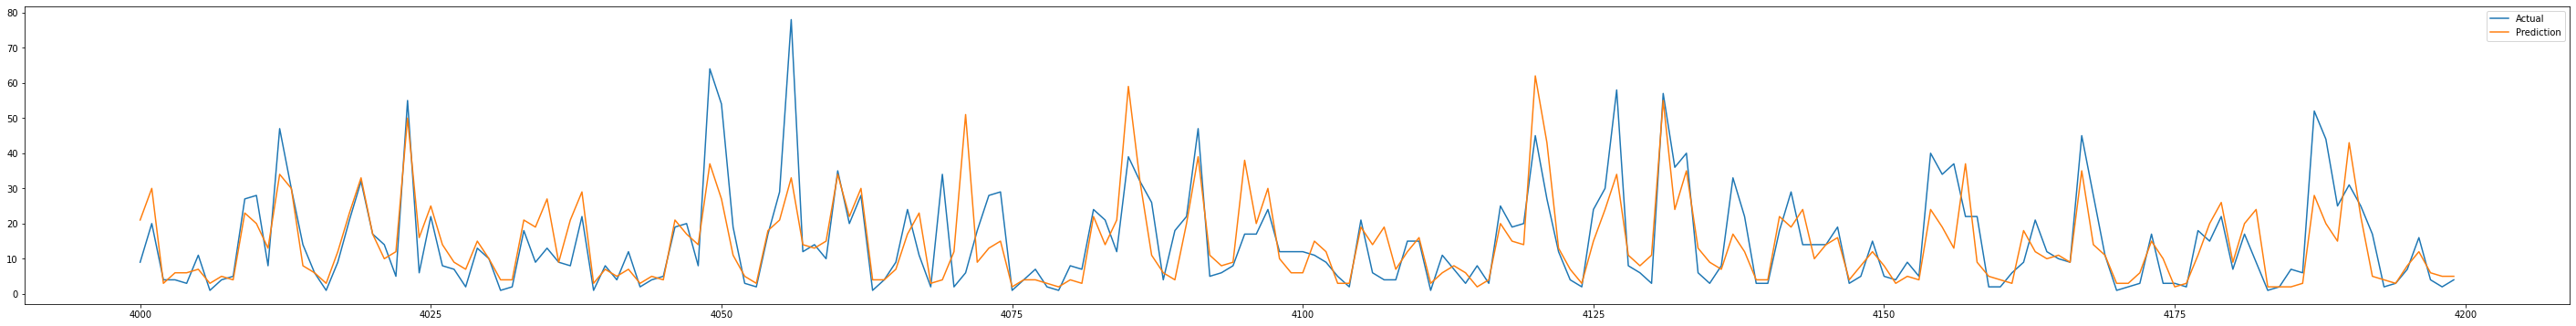

In [48]:
plot_actual_pred_lstm(tuned_lstm_test_actual, tuned_lstm_test_pred)

##### TSCV

In [59]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Dropout

tuned_lstm = Sequential()    
# Input layer
tuned_lstm.add(Input(shape=(2, 13)))
# First LSTM layer with hyperparameters for units, activation, dropout
tuned_lstm.add(LSTM(units=128,  
                return_sequences=True, 
                activation='relu'))
tuned_lstm.add(Dropout(0.2))
# Second LSTM layer with hyperparameters for units, activation, dropout
tuned_lstm.add(LSTM(units=128,
                return_sequences=False, 
                activation='tanh'))
tuned_lstm.add(Dropout(0.1)) 
# Dense layer
tuned_lstm.add(Dense(1, activation='linear'))
tuned_lstm.compile(optimizer=Adam(learning_rate=0.001), 
                   loss='mean_absolute_error', 
                   metrics=[r_squared])
early_stopper = EarlyStopping(monitor='val_loss', patience=5) 
history = tuned_lstm.fit(lstm_X_train, lstm_Y_train, epochs=10, batch_size=128, validation_data=(lstm_X_test, lstm_Y_test), callbacks=[early_stopper])

Epoch 1/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 62s 20ms/step - loss: 0.6171 - r_squared: -174.2960 - val_loss: 0.5409 - val_r_squared: -189.3402
Epoch 2/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - loss: 0.5107 - r_squared: -197.7849 - val_loss: 0.5327 - val_r_squared: -204.2882
Epoch 3/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 56s 22ms/step - loss: 0.4903 - r_squared: -202.6080 - val_loss: 0.5184 - val_r_squared: -193.0714
Epoch 4/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 57s 22ms/step - loss: 0.4809 - r_squared: -203.9460 - val_loss: 0.5135 - val_r_squared: -194.8704
Epoch 5/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 59s 23ms/step - loss: 0.4723 - r_squared: -205.2630 - val_loss: 0.5174 - val_r_squared: -200.5504
Epoch 6/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 58s 23ms/step - loss: 0.4691 - r_squared: -206.2256 - val_loss: 0.5069 - val_r_squared: -198.4792
Epoch 7/10
2549/2549 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - loss: 0.4642 - r_squared: -206.9186 - val_loss: 0.5078 - val_r_squared: -193.9411
Epoch 8/10
2549/2549

In [60]:
lstm_time_series_cross_validation(tuned_lstm)


Fold: 0
	Train Indices:  [    0     1     2 ... 68209 68210 68211]
	Test Indices:  [ 68212  68213  68214 ... 136416 136417 136418]
Train Sequence Data:  (68210, 2, 13) (68210,)
Epoch 1/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 0.4642 - r_squared: -207.0666
Epoch 2/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.4465 - r_squared: -210.2093
Epoch 3/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.4402 - r_squared: -210.7190
Epoch 4/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.4355 - r_squared: -211.5912
Epoch 5/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.4376 - r_squared: -211.7341
Epoch 6/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.4330 - r_squared: -212.7472
Epoch 7/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.4336 - r_squared: -211.7983
Epoch 8/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.4298 - r_squared: -212.6441
Epoch 9/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.4280 - r_squared: -213